Dataset loaded successfully!
Training set shape: (14622, 3)
Testing set shape: (3656, 3)
Class distribution in training set:
 target
1    13333
2     1289
Name: count, dtype: int64
✅ Fixed! X_train: (14573, 11, 1), y_train: (14573,)
✅ Fixed! X_test: (3607, 11, 1), y_test: (3607,)
Class distribution after SMOTE: Counter({0: 13287, 1: 13287})
Epoch 1/33
208/208 [==============================] - 171s 724ms/step - loss: 0.6795 - accuracy: 0.5669 - val_loss: 0.6237 - val_accuracy: 0.5351 - lr: 5.0000e-04
Epoch 2/33
208/208 [==============================] - 110s 530ms/step - loss: 0.6676 - accuracy: 0.5882 - val_loss: 0.7488 - val_accuracy: 0.3180 - lr: 5.0000e-04
Epoch 3/33
208/208 [==============================] - 110s 529ms/step - loss: 0.6644 - accuracy: 0.5900 - val_loss: 0.6215 - val_accuracy: 0.6060 - lr: 5.0000e-04
Epoch 4/33
208/208 [==============================] - 110s 530ms/step - loss: 0.6627 - accuracy: 0.5977 - val_loss: 0.6951 - val_accuracy: 0.4985 - lr: 5.0000e-04
Epoch

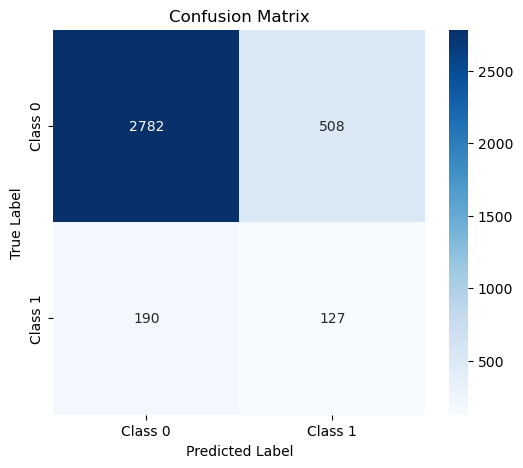

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      3290
           1       0.20      0.40      0.27       317

    accuracy                           0.81      3607
   macro avg       0.57      0.62      0.58      3607
weighted avg       0.87      0.81      0.83      3607



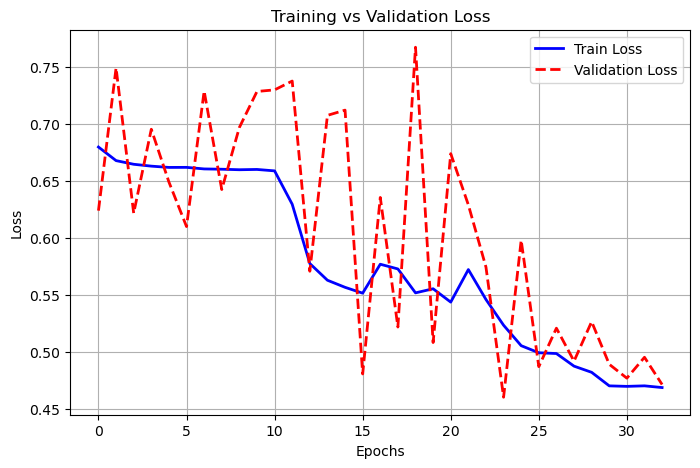

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy.fftpack import fft
import antropy as ant
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import LeakyReLU

# **1️⃣ Load and Merge Datasets**
df111 = pd.read_csv('data split/amm1.csv')
df122 = pd.read_csv('data split/amm.csv')
# df133 = pd.read_csv('data split/amm2.csv')
# df144 = pd.read_csv('data split/amm3.csv')
# df155 = pd.read_csv('data split/amm4.csv')
df177 = pd.read_csv('data split/ace1.csv')
df188 = pd.read_csv('data split/ace2.csv')
df199 = pd.read_csv('data split/ace3.csv')
df166 = pd.read_csv('data split/for1.csv')
df1112 = pd.read_csv('data split/for2.csv')
# df1113 = pd.read_csv('data split/for3.csv')
# df1012 = pd.read_csv('data split/for4.csv')
# df2 = pd.read_csv('data split/target1_2.csv')
# df3 = pd.read_csv('data split/target1_1.csv')
# df6 = pd.read_csv('data split/target2_1.csv')
# df7 = pd.read_csv('data split/target3_2_1.csv')
# # df8 = pd.read_csv('data split/target2_2.csv')
# df9 = pd.read_csv('data split/target3_3_2.csv')
# df10 = pd.read_csv('data split/target1_3.csv')
# df11 = pd.read_csv('data split/target2_3.csv')
# df12 = pd.read_csv('data split/target3_3_1.csv')
# df15 = pd.read_csv('data split/target2_2.csv')
# df16 = pd.read_csv('data split/target2_2.csv')
# df17 = pd.read_csv('data split/target3_2_2.csv')
# df18 = pd.read_csv('data split/target3_1_1.csv')
# df19 = pd.read_csv('data split/target4_3_1.csv')
# df191 = pd.read_csv('data split/target4_3_2.csv')
# df192 = pd.read_csv('data split/target4_3_3.csv')
# df193 = pd.read_csv('data split/target4_3_4.csv')


# # Merge related datasets
df13 = pd.concat([df177, df188, df199,df166,df1112], ignore_index=True)
df14 = pd.concat([ df111, df122], ignore_index=True)

# Assign class labels
df13['target'] = 2  # Class 1
df14['target'] = 1  # Class 2

# Combine all datasets
df_combined = pd.concat([df13, df14], ignore_index=True)


# Keep required columns and remove NaN values
df_combined = df_combined[['Time', 'I1', 'target']].dropna()

# Split dataset into training and testing sets
df_train_split, df_test_split = train_test_split(df_combined, test_size=0.2, random_state=42, stratify=df_combined['target'])

print("Dataset loaded successfully!")
print("Training set shape:", df_train_split.shape)
print("Testing set shape:", df_test_split.shape)
print("Class distribution in training set:\n", df_train_split['target'].value_counts())

# **2️⃣ Feature Extraction Function**
def extract_meta_features(time_series, time_series_time):
    features = {}

    # Mean, Standard Deviation, Min, Max
    features['mean'] = np.mean(time_series)
    features['std_dev'] = np.std(time_series)
    features['min'] = np.min(time_series)
    features['max'] = np.max(time_series)

    # Skewness & Kurtosis
    features['skewness'] = stats.skew(time_series)
    features['kurtosis'] = stats.kurtosis(time_series)

    # Linear Trend Slope
    x = time_series_time.reshape(-1, 1)
    model = LinearRegression().fit(x, time_series)
    features['trend_slope'] = model.coef_[0]

    # FFT Peak Frequency
    fft_vals = np.abs(fft(time_series))
    fft_freqs = np.fft.fftfreq(len(time_series))
    peak_freq = fft_freqs[np.argmax(fft_vals[1:])]
    features['fft_peak_freq'] = peak_freq

    # Spectral Entropy
    features['spectral_entropy'] = ant.spectral_entropy(time_series, sf=1, method='fft')

    # Number of Peaks & Troughs
    peaks, _ = find_peaks(time_series)
    troughs, _ = find_peaks(-time_series)
    features['num_peaks'] = len(peaks)
    features['num_troughs'] = len(troughs)

    return np.array(list(features.values()))


# **3️⃣ Feature Extraction for Training**
X_train = []
y_train = []

for i in range(len(df_train_split) - 49):  # Ensuring only full 50-sample sequences
    seq = df_train_split['I1'].iloc[i:i+50].to_numpy()
    time_seq = df_train_split['Time'].iloc[i:i+50].to_numpy()
    
    if len(seq) == 50 and len(time_seq) == 50:  # Validate exact 50-sample sequences
        X_train.append(extract_meta_features(seq, time_seq))  
        y_train.append(df_train_split['target'].iloc[i+49])  # Last value in window as label

# Convert lists to numpy arrays
X_train = np.array(X_train).reshape(len(X_train), -1, 1)  
y_train = np.array(y_train)

# **Check for mismatches**
if X_train.shape[0] != y_train.shape[0]:
    print(f"❌ Mismatch! X_train: {X_train.shape[0]}, y_train: {y_train.shape[0]}")
else:
    print(f"✅ Fixed! X_train: {X_train.shape}, y_train: {y_train.shape}")


X_test = []
y_test = []

for i in range(len(df_test_split) - 49):
    seq = df_test_split['I1'].iloc[i:i+50].to_numpy()
    time_seq = df_test_split['Time'].iloc[i:i+50].to_numpy()
    
    if len(seq) == 50 and len(time_seq) == 50:
        X_test.append(extract_meta_features(seq, time_seq))
        y_test.append(df_test_split['target'].iloc[i+49])

X_test = np.array(X_test).reshape(len(X_test), -1, 1)
y_test = np.array(y_test)

# **Check for mismatches**
if X_test.shape[0] != y_test.shape[0]:
    print(f"❌ Mismatch! X_test: {X_test.shape[0]}, y_test: {y_test.shape[0]}")
else:
    print(f"✅ Fixed! X_test: {X_test.shape}, y_test: {y_test.shape}")


# Adjust labels
y_train = df_train_split['target'].values[-X_train.shape[0]:] - 1  # Convert to [0, 1]
y_test = df_test_split['target'].values[-X_test.shape[0]:] - 1

# **4️⃣ Apply SMOTE for Class Balance**
def apply_smote(X, y):
    X_flat = X.reshape(X.shape[0], -1)
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_flat, y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], X.shape[1], 1)
    return X_resampled, y_resampled

X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# **5️⃣ Reward Function for RL Updates**
def reward_function(y_true, y_pred, X):
    error = np.abs(y_true - y_pred)
    reward = 1.0 / (1.0 + np.mean(error))  # Higher reward for lower error
    return reward

# Increase model complexity with more units in LSTM layers
meta_model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train_resampled.shape[1], 1)),
    Dropout(0.5),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    LeakyReLU(alpha=0.1),
    Dense(1, activation='sigmoid')
])

# Optimizer with a smaller learning rate and momentum
optimizer = Adam(learning_rate=0.0005)
meta_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = meta_model.fit(X_train_resampled, y_train_resampled,
                         epochs=33, batch_size=128,  # Higher batch size and epochs
                         validation_data=(X_test, y_test),
                         callbacks=[reduce_lr, early_stopping])

# Evaluate model on the test data
loss, accuracy = meta_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Generate predictions
y_pred = meta_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))



import matplotlib.pyplot as plt

# **Plot Training vs Validation Loss**
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
